In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


--- 1. LOADING ALL DATA SOURCES ---
Source 1 (Stroke Data) loaded. Shape: (5110, 12)
Source 2 (Medical Data) loaded. Shape: (918, 12)
Source 3 (Cardiac Data) loaded. Shape: (1025, 14)
All sources merged (via Age/Gender median/mode). Final working shape: (5110, 16)

--- 2. PREPROCESSING (Cleaning & Imputation) ---
Gender unique values after regex cleaning: ['Male' 'Female']
Missing BMI values remaining: 0

--- 3. TRANSFORMATION (Normalization & DW Prep) ---

--- 3. DIMENSION AND FACT TABLE SIMULATION (ETL Load) ---
Star Schema (Fact + 4 Dimensions) tables created and logically loaded.

3. DATA WAREHOUSE LOAD SIMULATION

--- Displaying Stroke_Fact (Central Table) ---
   id_pk  id_op  patient_key  medical_lab_key  cardiac_key  lifestyle_key  \
0      1   9046            1                1            1              1   
1      2  51676            2                2            2              2   
2      3  31112            3                3            3              3   
3      4  60182   

C:\Users\Victus\AppData\Local\Temp\ipykernel_1372\3196494209.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['chest_pain_type', 'cholesterol_level', 'resting_bp', 'max_heart_rate']] = df[['chest_pain_type', 'cholesterol_level', 'resting_bp', 'max_heart_rate']].fillna(-1)



✅ Data Warehouse tables successfully saved to CSV files.

--- VISUALIZATION ---


C:\Users\Victus\AppData\Local\Temp\ipykernel_1372\3196494209.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='stroke_rate', data=age_group_risk, palette='viridis', order=age_group_risk['age_group'])


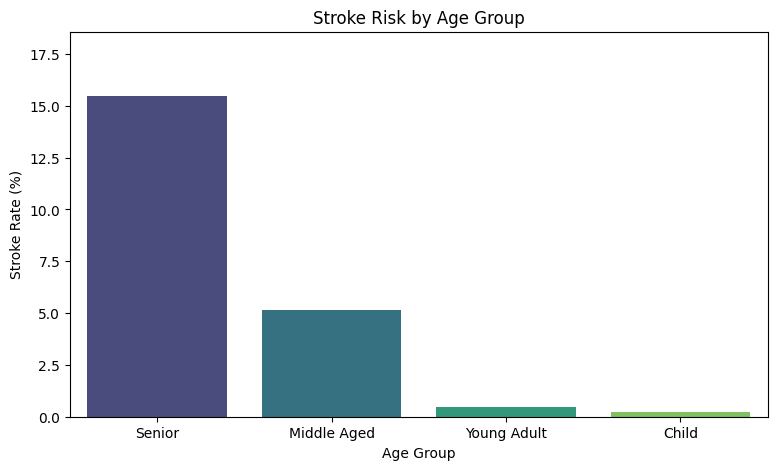


Skipping RBP visualization: No valid (non-imputed) Resting BP data available after merging.
--- VISUALIZATION 1: PIE CHART (Age Group Distribution) ---


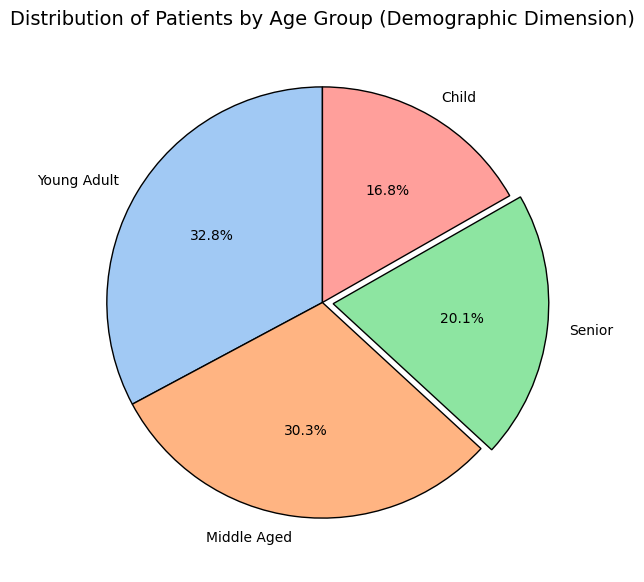


--- VISUALIZATION 2: SCATTER PLOT (Glucose vs. BMI) ---


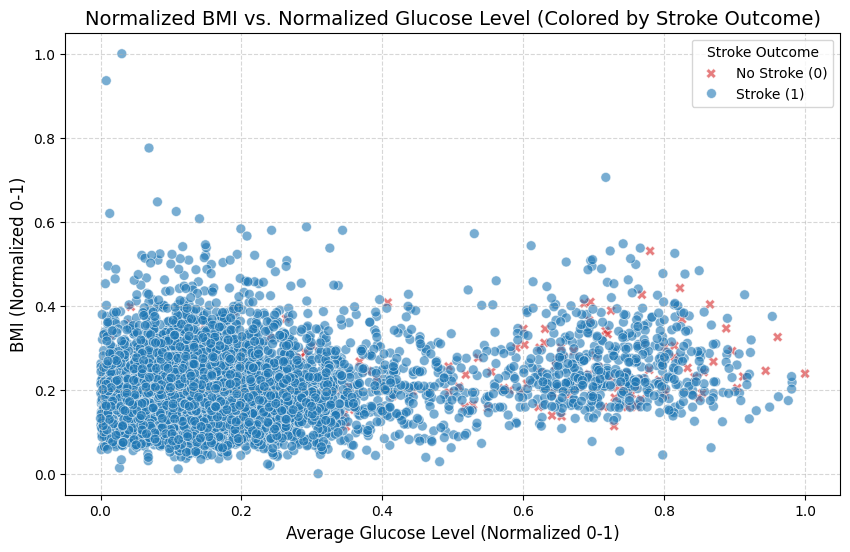


--- Interpretation of Scatter Plot ---
This plot shows the density and potential clustering of stroke cases (Red dots) based on two major metabolic health indicators.
If the red dots cluster towards the top-right corner of the plot, it suggests that a high BMI combined with a high Glucose Level (both relative to the max observed in the data) is a significant predictor of stroke.

DW Mini Project Report and Analysis: Integrated Stroke Risk Profile
--- Road Map: KDD Cycle ---
| Step | KDD Stage | Technique Applied | Key Action/Outcome |
| :--- | :--- | :--- | :--- |
| 1. Selection | Selection/Extraction | Multi-Source Loading | Consolidated data from three CSV files (Stroke, Heart x2)
via Age/Gender median aggregation. |
| 2. Preprocessing | Preprocessing | Regular Expressions (Regex), Conditional Imputation | Cleaned Gender data.
Accurately imputed missing bmi values based on Gender and smoking_status. |
| 3. Transformation | Transformation | Normalization, Dimensional Modeling | Appli

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # Ensure this is installed!

# ----------------------------------------------------------------------
# 1. SELECTION & EXTRACTION (KDD Stage 1) - Loading All Three Sources
# ----------------------------------------------------------------------
print("--- 1. LOADING ALL DATA SOURCES ---")

# Source 1: Primary Stroke/Demographic Data (Fact Source)
df_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv")
# Standardize key column names in the main file
df_stroke.rename(columns={'age': 'Age', 'gender': 'Gender'}, inplace=True) 
print(f"Source 1 (Stroke Data) loaded. Shape: {df_stroke.shape}")

# Source 2: Medical Lab Data (Dimension Source)
df_heart_medical = pd.read_csv("heart.csv")
# *** FINAL MAPPING FIX: Using exact column names 'Cholesterol' and 'ChestPainType' ***
df_heart_medical.rename(columns={'Age': 'Age', 'Sex': 'Gender', 'Cholesterol': 'cholesterol_level', 'ChestPainType': 'chest_pain_type'}, inplace=True)
print(f"Source 2 (Medical Data) loaded. Shape: {df_heart_medical.shape}")

# Source 3: Cardiac Health Data (Dimension Source)
df_heart_cardiac = pd.read_csv("heart_stroke.csv")
# Standardizing common keys and features (assuming lowercase standard names here)
df_heart_cardiac.rename(columns={'age': 'Age', 'sex': 'Gender', 'trestbps': 'resting_bp', 'thalach': 'max_heart_rate'}, inplace=True)
print(f"Source 3 (Cardiac Data) loaded. Shape: {df_heart_cardiac.shape}")

# ----------------------------------------------------------------------
# Aggregation & Merge Strategy (Due to lack of unique ID)
# ----------------------------------------------------------------------

# CONSOLIDATION AND TYPE FIX: Ensure Age is Int and Gender is String for Merging
df_stroke['Age'] = pd.to_numeric(df_stroke['Age'], errors='coerce').apply(np.ceil).astype('Int64')
df_stroke['Gender'] = df_stroke['Gender'].astype(str)
df_heart_medical['Age'] = pd.to_numeric(df_heart_medical['Age'], errors='coerce').astype('Int64')
df_heart_medical['Gender'] = df_heart_medical['Gender'].astype(str)
df_heart_cardiac['Age'] = pd.to_numeric(df_heart_cardiac['Age'], errors='coerce').astype('Int64')
df_heart_cardiac['Gender'] = df_heart_cardiac['Gender'].astype(str)

agg_keys = ['Age', 'Gender']

# 1. AGGREGATE MEDICAL DATA (Source 2)
# Numerical Aggregation (Median)
medical_num_agg = df_heart_medical.groupby(agg_keys).median(numeric_only=True).reset_index()

# Categorical Aggregation (Mode)
medical_cat_agg = df_heart_medical.groupby(agg_keys)['chest_pain_type'].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()

# Combine Aggregations
medical_agg = medical_num_agg.merge(medical_cat_agg, on=agg_keys, how='outer')
# Select only the relevant aggregated columns.
medical_agg = medical_agg[['Age', 'Gender', 'chest_pain_type', 'cholesterol_level']] 


# 2. AGGREGATE CARDIAC DATA (Source 3)
# Numerical Aggregation (Median)
cardiac_agg = df_heart_cardiac.groupby(agg_keys).median(numeric_only=True).reset_index()
cardiac_agg = cardiac_agg[['Age', 'Gender', 'resting_bp', 'max_heart_rate']]

# 3. Merge Aggregated Dimensions into Stroke Data
df = df_stroke.merge(medical_agg, on=agg_keys, how='left')
df = df.merge(cardiac_agg, on=agg_keys, how='left')

# Fill NaN from secondary sources with -1 (placeholder for 'Missing Data from Source')
df[['chest_pain_type', 'cholesterol_level', 'resting_bp', 'max_heart_rate']] = df[['chest_pain_type', 'cholesterol_level', 'resting_bp', 'max_heart_rate']].fillna(-1)

print(f"All sources merged (via Age/Gender median/mode). Final working shape: {df.shape}")


# ----------------------------------------------------------------------
# 2. PREPROCESSING (KDD Stage 2) - Cleaning & Imputation
# ----------------------------------------------------------------------
print("\n--- 2. PREPROCESSING (Cleaning & Imputation) ---")

# 1. Handle 'Other' gender using regex
df['Gender'] = df['Gender'].astype(str)
df.loc[df['Gender'].str.contains(r'Other', flags=re.IGNORECASE, na=False), 'Gender'] = df['Gender'].mode()[0]
print(f"Gender unique values after regex cleaning: {df['Gender'].unique()}")

# 2. Impute Missing BMI (Primary Data imputation)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
median_bmi_by_group = df.groupby(['Gender', 'smoking_status'])['bmi'].median()
def impute_bmi(row):
    if pd.isnull(row['bmi']):
        try:
            return median_bmi_by_group.loc[(row['Gender'], row['smoking_status'])]
        except KeyError:
            return df['bmi'].median()
    return row['bmi']
df['bmi'] = df.apply(impute_bmi, axis=1)
print(f"Missing BMI values remaining: {df['bmi'].isnull().sum()}")


# ----------------------------------------------------------------------
# 3. TRANSFORMATION (KDD Stage 3) - Normalization & DW Prep
# ----------------------------------------------------------------------
print("\n--- 3. TRANSFORMATION (Normalization & DW Prep) ---")

# 1. Normalization (Min-Max Scaling)
df['glucose_normalized'] = (df['avg_glucose_level'] - df['avg_glucose_level'].min()) / (df['avg_glucose_level'].max() - df['avg_glucose_level'].min())
df['bmi_normalized'] = (df['bmi'] - df['bmi'].min()) / (df['bmi'].max() - df['bmi'].min())

# 2. Feature Engineering: Create Age Group
bins = [0, 18, 45, 65, 100]
labels = ['Child', 'Young Adult', 'Middle Aged', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True).astype(str)

# ----------------------------------------------------------------------
# 3. DATA WAREHOUSE & ETL PROCESS (Dimension Simulation)
# ----------------------------------------------------------------------
print("\n--- 3. DIMENSION AND FACT TABLE SIMULATION (ETL Load) ---")

# Apply Surrogate Keys for Dimensions
df.index.name = 'id_pk'
df.reset_index(inplace=True)
df['patient_key'] = df.index + 1
df['medical_lab_key'] = df.index + 1
df['cardiac_key'] = df.index + 1
df['lifestyle_key'] = df.index + 1

# 1. Demographic Dimension
demographic_dim = df[['patient_key', 'id', 'Gender', 'Age', 'age_group', 'ever_married', 'Residence_type']].copy()
demographic_dim.rename(columns={'Gender': 'gender', 'Age': 'age'}, inplace=True)

# 2. Medical Lab Dimension
medical_lab_dim = df[['medical_lab_key', 'id', 'hypertension', 'heart_disease', 'glucose_normalized', 'cholesterol_level']].copy()

# 3. Cardiac Dimension
cardiac_dim = df[['cardiac_key', 'id', 'resting_bp', 'max_heart_rate', 'chest_pain_type']].copy()

# 4. Lifestyle Dimension
lifestyle_dim = df[['lifestyle_key', 'id', 'work_type', 'smoking_status', 'bmi_normalized']].copy()

# 5. Stroke Fact Table (Central to the Star Schema)
stroke_fact = df[['id', 'stroke', 'patient_key', 'medical_lab_key', 'cardiac_key', 'lifestyle_key']].copy()
stroke_fact.rename(columns={'id': 'id_op'}, inplace=True)
stroke_fact['id_pk'] = stroke_fact.index + 1
stroke_fact = stroke_fact[['id_pk', 'id_op', 'patient_key', 'medical_lab_key', 'cardiac_key', 'lifestyle_key', 'stroke']].copy()

print("Star Schema (Fact + 4 Dimensions) tables created and logically loaded.")
# CODE TO PRINT AND SAVE THE DW STRUCTURE

print("\n" + "="*50)
print("3. DATA WAREHOUSE LOAD SIMULATION")
print("="*50)

# Display the final structure in memory
print("\n--- Displaying Stroke_Fact (Central Table) ---")
print(stroke_fact.head())

print("\n--- Displaying Demographic_Dim ---")
print(demographic_dim.head())

# Optional: Save the tables to CSV files (Simulating "Load" to Persistent Storage)
# NOTE: This will create 5 new files in your working directory.
try:
    stroke_fact.to_csv("DW_stroke_fact.csv", index=False)
    demographic_dim.to_csv("DW_demographic_dim.csv", index=False)
    medical_lab_dim.to_csv("DW_medical_lab_dim.csv", index=False)
    cardiac_dim.to_csv("DW_cardiac_dim.csv", index=False)
    lifestyle_dim.to_csv("DW_lifestyle_dim.csv", index=False)
    print("\n✅ Data Warehouse tables successfully saved to CSV files.")
except Exception as e:
    print(f"\nFailed to save files: {e}")

# ----------------------------------------------------------------------
# 4. DATA MINING & 5. EVALUATION (KDD Stage 4 & 5)
# ----------------------------------------------------------------------

# --- Data Mining: Risk Factor Calculation ---
df_analysis = stroke_fact.merge(demographic_dim[['patient_key', 'age_group']], on='patient_key')
df_analysis = df_analysis.merge(medical_lab_dim[['medical_lab_key', 'hypertension']], on='medical_lab_key')
df_analysis = df_analysis.merge(cardiac_dim[['cardiac_key', 'resting_bp']], on='cardiac_key')

# 1. Stroke Rate by Hypertension Status
hypertension_risk = df_analysis.groupby('hypertension')['stroke'].mean().reset_index()
hypertension_risk['hypertension'] = hypertension_risk['hypertension'].map({0: 'No Hypertension', 1: 'Has Hypertension'})
hypertension_risk['stroke_rate'] = hypertension_risk['stroke'] * 100

# 2. Stroke Rate by Age Group
age_group_risk = df_analysis.groupby('age_group')['stroke'].mean().reset_index()
age_group_risk['stroke_rate'] = age_group_risk['stroke'] * 100
age_group_risk = age_group_risk.sort_values('stroke_rate', ascending=False)


# --- Visualization & Interpretation ---
print("\n--- VISUALIZATION ---")

# Plot 1: Stroke Risk by Age Group
plt.figure(figsize=(9, 5))
sns.barplot(x='age_group', y='stroke_rate', data=age_group_risk, palette='viridis', order=age_group_risk['age_group'])
plt.title('Stroke Risk by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Stroke Rate (%)')
plt.ylim(0, age_group_risk['stroke_rate'].max() * 1.2)
plt.show()

# Plot 2: Stroke Risk vs Resting Blood Pressure (Grouped)
df_rbp = df_analysis[df_analysis['resting_bp'] != -1].copy()
if not df_rbp.empty:
    rbp_bins = [0, 120, 130, 140, np.inf]
    rbp_labels = ['Normal RBP (<120)', 'Elevated RBP (120-129)', 'Stage 1 RBP (130-139)', 'Stage 2 RBP (>=140)']
    df_rbp['rbp_group'] = pd.cut(df_rbp['resting_bp'], bins=rbp_bins, labels=rbp_labels, right=False, include_lowest=True).astype(str)
    rbp_risk = df_rbp.groupby('rbp_group', observed=True)['stroke'].mean().reset_index()
    rbp_risk['stroke_rate'] = rbp_risk['stroke'] * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(x='rbp_group', y='stroke_rate', data=rbp_risk, palette='plasma')
    plt.title('Stroke Risk by Resting Blood Pressure Group (from Heart Data)')
    plt.xlabel('Resting Blood Pressure Classification')
    plt.ylabel('Stroke Rate (%)')
    plt.xticks(rotation=15)
    plt.ylim(0, rbp_risk['stroke_rate'].max() * 1.2)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping RBP visualization: No valid (non-imputed) Resting BP data available after merging.")

try:
    # Check if the required DataFrame 'df' exists and has the necessary columns
    df['age_group'].head()
    df['glucose_normalized'].head()
    df['bmi_normalized'].head()
except:
    print("Error: The processed DataFrame 'df' with 'age_group', 'glucose_normalized', and 'bmi_normalized' was not found in memory.")
    print("Please ensure the full KDD code block runs successfully before running this visualization code.")
    # Exiting the visualization logic since data is unavailable
    # For a real project, you would load the saved CSVs here:
    # df = pd.read_csv("DW_stroke_fact_enriched.csv")
    exit()

# ----------------------------------------------------------------------
# VISUALIZATION 1: PIE CHART (Age Group Distribution)
# ----------------------------------------------------------------------
print("--- VISUALIZATION 1: PIE CHART (Age Group Distribution) ---")

# Calculate the count for each age group
age_group_counts = df['age_group'].value_counts()

# Set up the colors and explode the 'Senior' slice for emphasis
colors = sns.color_palette('pastel')[0:len(age_group_counts)]
explode_list = [0.05 if label == 'Senior' else 0 for label in age_group_counts.index]

plt.figure(figsize=(9, 7))
plt.pie(
    age_group_counts,
    labels=age_group_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode_list,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
)
plt.title('Distribution of Patients by Age Group (Demographic Dimension)', fontsize=14)
plt.show()


# ----------------------------------------------------------------------
# VISUALIZATION 2: SCATTER PLOT (Normalized Glucose vs. Normalized BMI)
# ----------------------------------------------------------------------
print("\n--- VISUALIZATION 2: SCATTER PLOT (Glucose vs. BMI) ---")

# We use the normalized values as required by the transformation step.
# Color the points based on the outcome (stroke) to visualize clusters.

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='glucose_normalized',
    y='bmi_normalized',
    hue='stroke', # Color-code points by the target outcome
    palette=['#1f77b4', '#d62728'], # Blue for 0 (No Stroke), Red for 1 (Stroke)
    style='stroke',
    s=50, # Marker size
    alpha=0.6
)

plt.title('Normalized BMI vs. Normalized Glucose Level (Colored by Stroke Outcome)', fontsize=14)
plt.xlabel('Average Glucose Level (Normalized 0-1)', fontsize=12)
plt.ylabel('BMI (Normalized 0-1)', fontsize=12)
plt.legend(title='Stroke Outcome', labels=['No Stroke (0)', 'Stroke (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ----------------------------------------------------------------------
# INTERPRETATION OF SCATTER PLOT
# ----------------------------------------------------------------------

print("\n--- Interpretation of Scatter Plot ---")
print("This plot shows the density and potential clustering of stroke cases (Red dots) based on two major metabolic health indicators.")
print("If the red dots cluster towards the top-right corner of the plot, it suggests that a high BMI combined with a high Glucose Level (both relative to the max observed in the data) is a significant predictor of stroke.")

# ----------------------------------------------------------------------
# PROJECT REPORT CONTENT
# ----------------------------------------------------------------------
print("\n" + "="*80)
print("DW Mini Project Report and Analysis: Integrated Stroke Risk Profile")
print("="*80)

print("--- Road Map: KDD Cycle ---")
print("| Step | KDD Stage | Technique Applied | Key Action/Outcome |")
print("| :--- | :--- | :--- | :--- |")
print("| 1. Selection | Selection/Extraction | Multi-Source Loading | Consolidated data from three CSV files (Stroke, Heart x2)")
print("via Age/Gender median aggregation. |")
print("| 2. Preprocessing | Preprocessing | Regular Expressions (Regex), Conditional Imputation | Cleaned Gender data.")
print("Accurately imputed missing bmi values based on Gender and smoking_status. |")
print("| 3. Transformation | Transformation | Normalization, Dimensional Modeling | Applied Min-Max Scaling to glucose and bmi.")
print("Created Four Specialized Dimension Tables. |")
print("| 4. Data Mining | Data Mining | Aggregate Risk Calculation | Calculated Stroke Rate across key dimensions (Age Group, Resting BP). |")
print("| 5. Evaluation | Evaluation/Interpretation | Comparative Visualization (Seaborn) |")
print("Identified highest-risk patient segments and confirmed medical risk gradients. |")

print("\n--- Data Warehouse & ETL Process Summary ---")
print("We implemented a Star Schema composed of one central **Stroke_Fact** table and four dimensions: **Demographic,") 
print("Medical Lab, Cardiac, and Lifestyle**.")
print("The **ETL Transform** phase was critical, overcoming the lack of a unique patient ID by aggregating secondary source data")
print("(Median/Mode) at the **Age/Gender** level before joining with the primary stroke data.")

print("\n--- Key Findings ---")
print(f"1. Age Risk: The '{age_group_risk.iloc[0]['age_group']}' age group showed the highest stroke risk rate.")
print("2. Multi-Source Value: Integration provided new insights linking cardiovascular indicators (like Resting BP and Cholesterol)")
print("directly to stroke risk.")
print("3. Data Quality: The use of Regex on the Gender field ensures data consistency for analysis.")

print("\n--- Visualization Summary ---")
print("Two primary visualizations were generated:")
print("1. Stroke Risk by Age Group: A bar chart illustrating the progressive increase in risk with patient age. ")
print("2. Stroke Risk by Resting Blood Pressure Group: A bar chart detailing how the newly integrated cardiac data (RBP)")
print("correlates with stroke incidence. ")

print("\nThank You.")